<a href="https://colab.research.google.com/github/srivatsan88/End-to-End-Time-Series/blob/master/Multivariate_Time_Series_using_VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from math import sqrt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# load dataset
stock_price_df = read_csv('./data/VN30.csv', header=0, index_col=0)
values = stock_price_df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
stock_price_df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2012-06-18,510.81,509.62,514.55,508.64,22.57,0.57
2012-06-19,506.67,508.37,510.60,505.02,12.69,-0.81
2012-06-20,508.23,507.23,510.37,504.02,10.66,0.31
2012-06-21,504.71,504.85,507.84,504.52,13.24,-0.69
2012-06-22,500.34,503.97,504.21,499.40,17.35,-0.87


In [2]:
column_names = stock_price_df.columns

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('{}(t-{})'.format(column_names[j], i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('{}(t)'.format(column_names[j])) for j in range(n_vars)]
		else:
			names += [('{}(t+{})'.format(column_names[j], i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [4]:
Shift_df = stock_price_df.copy()

In [5]:
for col in column_names:
    stock_price_df["Diff" + column_names] = stock_price_df[column_names].diff()

In [6]:
n_days_lag = 20
n_features = len(column_names)

reframed = series_to_supervised(stock_price_df[[f"Diff{col}" for col in column_names]], n_days_lag, 1)


In [7]:
reframed.head()

,Price(t-20),Open(t-20),High(t-20),Low(t-20),Vol.(t-20),Change %(t-20),Price(t-19),Open(t-19),High(t-19),Low(t-19),...,High(t-1),Low(t-1),Vol.(t-1),Change %(t-1),Price(t),Open(t),High(t),Low(t),Vol.(t),Change %(t)
Date,,,,,,,,,,,,,,,,,,,,,
2012-07-17,-4.14,-1.25,-3.95,-3.62,-9.88,-1.38,1.56,-1.14,-0.23,-1.00,...,1.62,3.52,-6.07,-2.67,4.41,-8.85,-0.64,-3.46,2.32,1.66
2012-07-18,1.56,-1.14,-0.23,-1.00,-2.03,1.12,-3.52,-2.38,-2.53,0.50,...,-0.64,-3.46,2.32,1.66,1.07,8.72,2.19,7.11,-0.04,-0.68
2012-07-19,-3.52,-2.38,-2.53,0.50,2.58,-1.00,-4.37,-0.88,-3.63,-5.12,...,2.19,7.11,-0.04,-0.68,8.49,0.88,6.99,1.30,13.12,1.50
2012-07-20,-4.37,-0.88,-3.63,-5.12,4.11,-0.18,-2.25,-4.60,-0.63,-2.97,...,6.99,1.30,13.12,1.50,-5.17,13.26,5.38,4.40,0.48,-2.75
2012-07-23,-2.25,-4.60,-0.63,-2.97,-0.91,0.42,-4.36,-2.65,-6.86,-4.09,...,5.38,4.40,0.48,-2.75,-1.57,-10.83,-7.65,-2.35,-9.91,0.71


In [8]:
# split into train and test sets
n_obs = n_days_lag * n_features

values = reframed.values
n_train_days = int(len(reframed.index) * 0.8)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
#y is the VN30 price
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
# reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], n_days_lag, n_features))
# test_X = test_X.reshape((test_X.shape[0], n_days_lag, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2091, 120) (2091, 6) (523, 120) (523, 6)


In [9]:
test_df = stock_price_df[n_train_days:]
train_df = stock_price_df[:n_train_days]

In [10]:
RFRoost_model = RandomForestRegressor()
RFRoost_model.fit(train_X, train_y)


RandomForestRegressor()

In [11]:
train_idx = stock_price_df.index <= reframed[:n_train_days].index[-1]
test_idx = ~train_idx

train_idx[:n_days_lag+1] = False

In [12]:
RFRoost_model.score(train_X, train_y)

0.9104294460516281

In [13]:
RFRoost_model.score(test_X, test_y)

0.2907387439408254

In [14]:
RFRoost_model.predict(train_X)[:, 1].shape

(2091,)

In [15]:
for i, col in enumerate(column_names):
    stock_price_df[f'Shift{col}'] = stock_price_df[col].shift(1)
    prev = stock_price_df[f'Shift{col}']
    stock_price_df.loc[train_idx, f'{col}-RFR_1_step_train'] = prev[train_idx] + RFRoost_model.predict(train_X)[:, i]
    stock_price_df.loc[test_idx, f'{col}-RFR_1_step_test'] = prev[test_idx] + RFRoost_model.predict(test_X)[:, i]

In [38]:
observe_date = reframed[n_train_days-10:].index[0]

<Axes: xlabel='Date'>

<Figure size 1000x600 with 0 Axes>

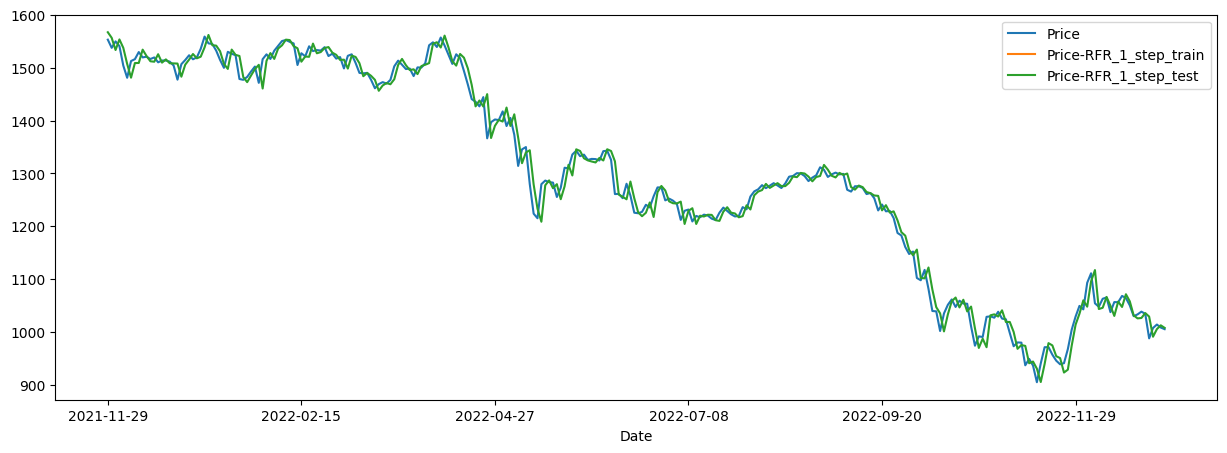

In [39]:
plt.figure(figsize=(10, 6))
stock_price_df[stock_price_df.index > observe_date][['Price', 'Price-RFR_1_step_train', 'Price-RFR_1_step_test']].plot(figsize=(15,5))

In [18]:
test_X[[0], :].shape

(1, 120)

In [19]:
test_X

array([[  6.72,   5.34,   6.61, ...,  10.23, -13.48,   0.35],
       [  2.87,   7.05,   4.75, ...,   2.2 ,  26.06,  -1.26],
       [  3.34,   2.65,   5.81, ..., -13.97,  44.69,   1.62],
       ...,
       [ 20.17,  27.2 ,  20.17, ...,  -2.1 , -21.57,   6.46],
       [ -6.57,  25.02,  24.11, ...,  11.45, -30.4 ,  -1.33],
       [ 50.35, -21.69,  19.67, ...,  11.18,  -2.23,  -1.21]])

In [20]:
n_observe_days = 5
multistep_forecasting = []
last_x = test_X[[0]]
while len(multistep_forecasting) < n_observe_days:
    p = RFRoost_model.predict(last_x)
    multistep_forecasting.append(p)
    last_x = np.roll(last_x, -n_features)
    for i in range(n_features):
        last_x[0, -(n_features-i)] = p[0, i]


In [21]:
import copy
multistep_idx = copy.deepcopy(test_idx)
multistep_idx[n_train_days+n_days_lag+1+n_observe_days:] = False
multistep_idx.sum()

5

In [22]:
for i, col in enumerate(column_names):
    last_train = stock_price_df.iloc[n_train_days+n_days_lag][col]
    stock_price_df.loc[multistep_idx, f'{col}-RFR_multistep'] = last_train + np.cumsum([p[0,i] for  p in multistep_forecasting])

<Axes: xlabel='Date'>

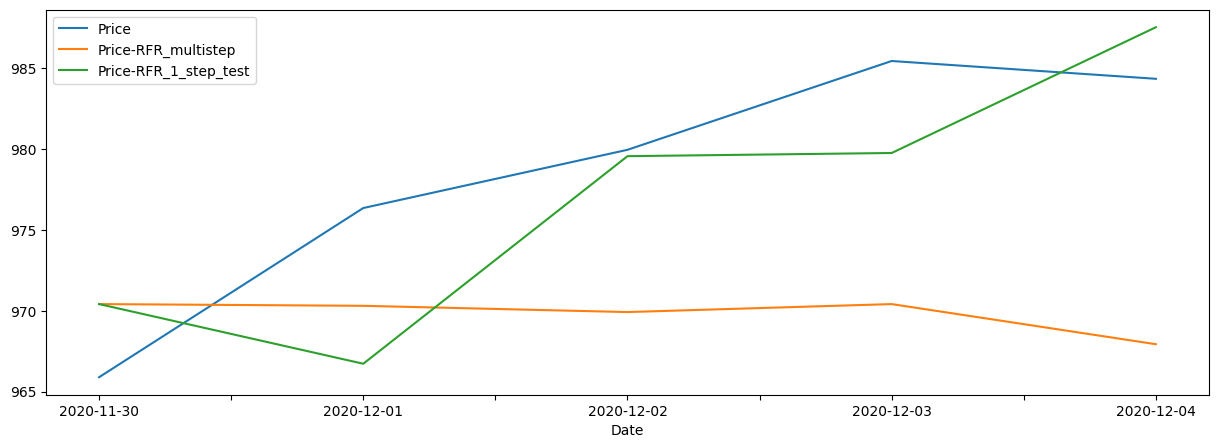

In [23]:
stock_price_df[multistep_idx][['Price', 'Price-RFR_multistep', 'Price-RFR_1_step_test']].plot(figsize=(15,5))

In [24]:
multiouput_df = series_to_supervised(stock_price_df[[f"Diff{col}" for col in column_names]], n_days_lag, n_observe_days)
n_obs = n_days_lag * n_features

values = multiouput_df.values
n_train_days = int(len(multiouput_df.index) * 0.9)
train_m = values[:n_train_days, :]
test_m = values[n_train_days:n_train_days+n_observe_days, :]
train_X_m, train_y_m = train_m[:, :n_obs], train_m[:, n_obs:]
test_X_m, test_y_m = test_m[:, :n_obs], test_m[:, n_obs:]
multioutput_RFRoost_model = RandomForestRegressor()
multioutput_RFRoost_model.fit(train_X_m, train_y_m)
multioutput_RFRoost_model.score(train_X_m, train_y_m)

0.8639121654438559

In [25]:
multiouput_df

,Price(t-20),Open(t-20),High(t-20),Low(t-20),Vol.(t-20),Change %(t-20),Price(t-19),Open(t-19),High(t-19),Low(t-19),...,High(t+3),Low(t+3),Vol.(t+3),Change %(t+3),Price(t+4),Open(t+4),High(t+4),Low(t+4),Vol.(t+4),Change %(t+4)
Date,,,,,,,,,,,,,,,,,,,,,
2012-07-17,-4.14,-1.25,-3.95,-3.62,-9.88,-1.38,1.56,-1.14,-0.23,-1.00,...,5.38,4.40,0.48,-2.75,-1.57,-10.83,-7.65,-2.35,-9.91,0.71
2012-07-18,1.56,-1.14,-0.23,-1.00,-2.03,1.12,-3.52,-2.38,-2.53,0.50,...,-7.65,-2.35,-9.91,0.71,-4.52,-2.35,-5.10,-5.83,-1.30,-0.59
2012-07-19,-3.52,-2.38,-2.53,0.50,2.58,-1.00,-4.37,-0.88,-3.63,-5.12,...,-5.10,-5.83,-1.30,-0.59,-2.97,-6.14,-3.80,-1.63,-1.24,0.31
2012-07-20,-4.37,-0.88,-3.63,-5.12,4.11,-0.18,-2.25,-4.60,-0.63,-2.97,...,-3.80,-1.63,-1.24,0.31,2.41,0.73,1.22,1.00,-1.92,1.09
2012-07-23,-2.25,-4.60,-0.63,-2.97,-0.91,0.42,-4.36,-2.65,-6.86,-4.09,...,1.22,1.00,-1.92,1.09,-1.17,4.02,1.23,-0.15,1.92,-0.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,-11.35,-14.33,13.03,-9.77,236.59,0.28,-6.81,-17.23,-33.32,-8.59,...,-7.47,-8.78,-58.65,-0.92,-46.36,-5.49,-8.20,-34.74,45.38,-4.07
2022-12-21,-6.81,-17.23,-33.32,-8.59,-214.08,0.47,2.03,-6.39,-10.17,-7.71,...,-8.20,-34.74,45.38,-4.07,19.59,-43.55,-18.16,-2.10,-21.57,6.46
2022-12-22,2.03,-6.39,-10.17,-7.71,-18.28,0.94,26.73,15.97,25.80,22.01,...,-18.16,-2.10,-21.57,6.46,6.59,20.32,8.23,11.45,-30.40,-1.33


In [26]:
multioutput_RFRoost_model.score(test_X_m, test_y_m)

-0.4459258307804747

In [27]:
test_X_m[[0]].shape

(1, 120)

In [28]:
multioutput_RFRoost_model.predict(test_X_m[[0]])[0,5]

-0.982

In [29]:
multiouput_predict = multioutput_RFRoost_model.predict(test_X_m[[0]])
for i, col in enumerate(column_names):
    last_train = stock_price_df.iloc[n_train_days+n_days_lag][col]
    stock_price_df.loc[multistep_idx, f'{col}-RFR_multioutput'] = last_train + np.cumsum([multiouput_predict[0, t*n_features+i] for t in range(n_observe_days)])

<Axes: xlabel='Date'>

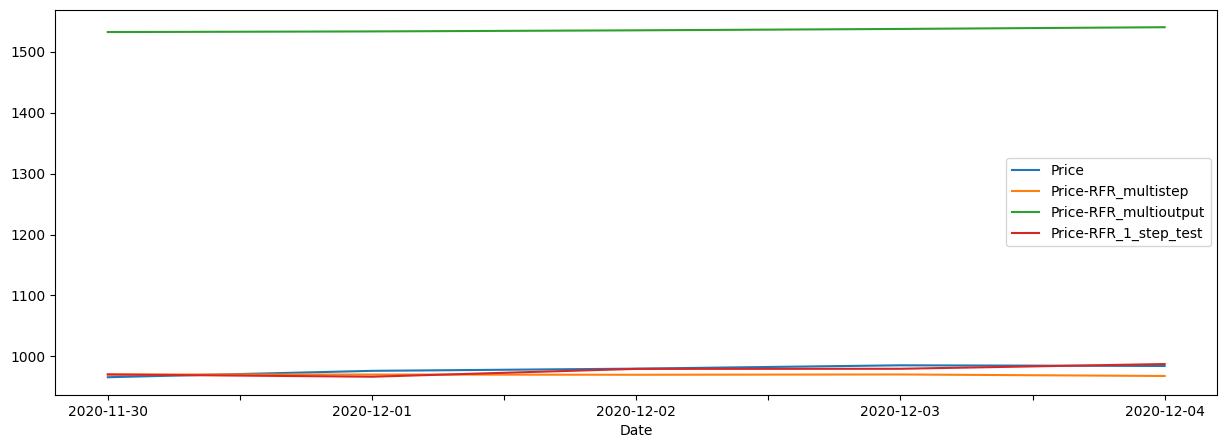

In [30]:
stock_price_df[multistep_idx][['Price', 'Price-RFR_multistep', 'Price-RFR_multioutput', 'Price-RFR_1_step_test']].plot(figsize=(15,5))

In [31]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
def adjust(val, length= 6): return str(val).ljust(length)


In [32]:
test = stock_price_df.copy()[['Price-RFR_multistep', 'Price-RFR_multioutput', 'Price']]
test.dropna(inplace=True)
print('\nForecast Accuracy of Incremental multistep (base on one step ahead): VN30')
accuracy_prod = forecast_accuracy(test['Price-RFR_multistep'].values, test['Price'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))
print('\nForecast Accuracy of Multi output model n_step ahead: VN30')
accuracy_prod = forecast_accuracy(test['Price-RFR_multioutput'].values, test['Price'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of Incremental multistep (base on one step ahead): VN30
mape   :  0.0106
me     :  -8.5986
mae    :  10.4074
mpe    :  -0.0087
rmse   :  11.4259
corr   :  -0.4577
minmax :  0.0106

Forecast Accuracy of Multi output model n_step ahead: VN30
mape   :  0.5695
me     :  557.1235
mae    :  557.1235
mpe    :  0.5695
rmse   :  557.1448
corr   :  0.8475
minmax :  0.3628


In [33]:
accuracy_prod = forecast_accuracy(test['Price-RFR_multioutput'].values, test['Price'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

mape   :  0.5695
me     :  557.1235
mae    :  557.1235
mpe    :  0.5695
rmse   :  557.1448
corr   :  0.8475
minmax :  0.3628


In [34]:
print('\nForecast Accuracy of One-step ahead: VN30')
test = stock_price_df.copy()[['Price-RFR_1_step_test', 'Price']]
test.dropna(inplace=True)
accuracy_prod = forecast_accuracy(test['Price-RFR_1_step_test'].values, test['Price'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of One-step ahead: VN30
mape   :  0.0112
me     :  -0.3369
mae    :  14.1784
mpe    :  -0.0002
rmse   :  19.7041
corr   :  0.9943
minmax :  0.011


<Axes: xlabel='Date'>

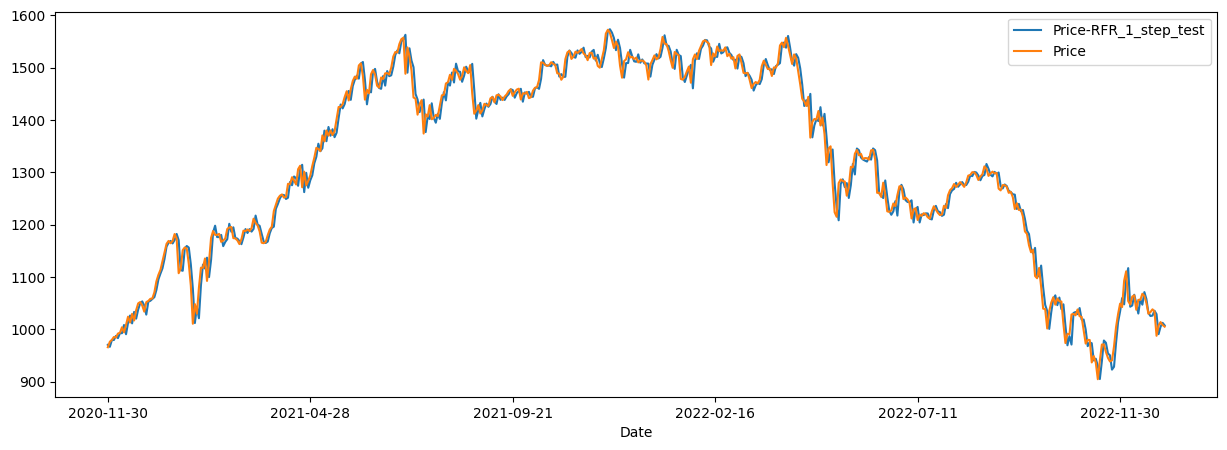

In [50]:
test.plot(figsize=(15,5))